<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install tensorflow
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 35kB/s 
     |████████████████████████████████| 3.9MB 41.2MB/s 
     |████████████████████████████████| 450kB 40.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=bc2ddb44c56df727324d8bbce5950850d0ec78fe42968598efc55093a2dda48b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc4 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc4 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc4 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Unins

In [2]:
pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [3]:
import tensorflow
import tensorflow.keras as keras

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation, Dropout
from keras.layers import BatchNormalization
from keras.metrics import BinaryAccuracy
from keras import optimizers


import pandas
import matplotlib.pyplot as plt
from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'
drive.mount(ROOT)
HOME = join(ROOT,'My Drive')
COLAB_DIR = join(HOME, 'Colab Notebooks')
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = data.drop(['Unnamed: 0', 'VAL', 'NUM_OF_TRANSACTIONS','CLOSE_ONE_DAY_BEFORE'], axis=1).rename(columns={'DTYYYYMMDD': 'DATE'})
data['DATE'] = pandas.to_datetime(data['DATE'],format='%Y%m%d')

In [5]:
labels = pandas.DataFrame()
labels['CLASS'] = numpy.where(data['CLOSE'] > data['CLOSE'].shift(1), 1.0, 0.0)
labels['DATE'] = data['DATE'].copy()
labels['TICKER'] = data['TICKER'].copy()
labels.head(10)

,CLASS,DATE,TICKER
0,0.0,2019-11-20,مظنه
1,0.0,2019-11-23,مظنه
2,0.0,2019-11-24,مظنه
3,0.0,2019-11-25,مظنه
4,0.0,2019-11-26,مظنه
5,0.0,2019-11-27,مظنه
6,0.0,2019-11-30,مظنه
7,0.0,2019-12-01,مظنه
8,0.0,2019-12-02,مظنه
9,0.0,2019-12-03,مظنه


Let's assert if we are using GPU.

In [6]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## **Visualization Task**

**Let's do some visualizations first to investigate data set we are working with**

In [7]:
mean_vol_per_ticker = data.groupby('TICKER')['VOL'].agg(numpy.mean).reset_index().sort_values('VOL', ascending=False)
mean_vol_per_ticker.head()

,TICKER,VOL
894,شاخص_قيمت(هم_وزن6),1.560700e+09
895,شاخص_قيمت6,1.559693e+09
898,شاخص_كل_(هم_وزن)6,1.559693e+09
889,شاخص_آزاد_شناور6,9.130124e+08
897,شاخص_كل6,8.711138e+08


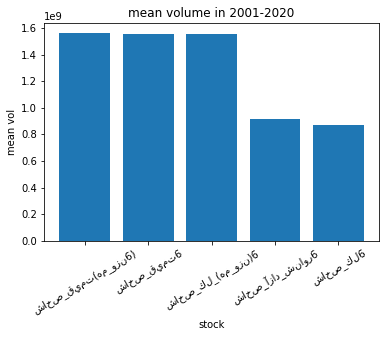

In [8]:
 five_first_stocks_with_mean_vol = mean_vol_per_ticker.head()
 index = numpy.arange(len(five_first_stocks_with_mean_vol['TICKER']))
 plt.bar(index, five_first_stocks_with_mean_vol['VOL'])
 plt.xlabel('stock', fontsize=10)
 plt.ylabel('mean vol', fontsize=10)
 plt.xticks(index, five_first_stocks_with_mean_vol['TICKER'], fontsize=10, rotation=30)
 plt.title('mean volume in 2001-2020')
 plt.show()

In [9]:
data_for_ticker_with_max_mean_vol = data[ data['TICKER'] == mean_vol_per_ticker.head().iloc[0]['TICKER'] ]
data_for_ticker_with_max_mean_vol.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL
3004878,شاخص_قيمت(هم_وزن6),2015-02-24,9198.4,9181.8,9181.8,9181.8,278521094
3004879,شاخص_قيمت(هم_وزن6),2015-02-25,9183.3,9109.1,9109.2,9109.1,271188153
3004880,شاخص_قيمت(هم_وزن6),2015-02-28,9111.9,9090.0,9090.0,9090.0,257849083
3004881,شاخص_قيمت(هم_وزن6),2015-03-01,9014.4,9030.4,9009.0,9030.4,475683577
3004882,شاخص_قيمت(هم_وزن6),2015-03-02,9034.4,9043.5,9034.4,9043.5,717632564


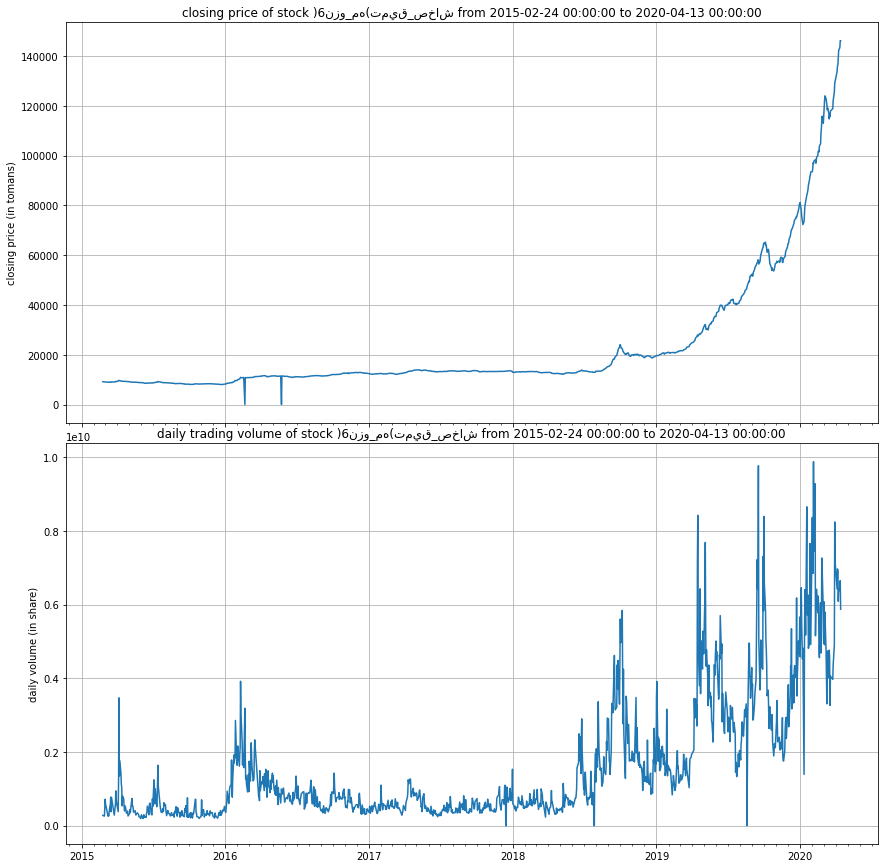

In [10]:
import matplotlib.dates as mdates

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,12))
fig.tight_layout()

ax1 = axs[0]
ax2 = axs[1]
starting_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[0])
ending_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[len(data_for_ticker_with_max_mean_vol) - 1])

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)


ax1.plot(data_for_ticker_with_max_mean_vol['DATE'], data_for_ticker_with_max_mean_vol['CLOSE'])
ax1.set(ylabel='closing price (in tomans)')
ax1.set_title('closing price of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date + ' to ' + ending_date)
ax2.plot(data_for_ticker_with_max_mean_vol['DATE'], data_for_ticker_with_max_mean_vol['VOL'])
ax2.set(ylabel='daily volume (in share)')
ax2.set_title('daily trading volume of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date + ' to ' + ending_date)

ax1.grid(True)
ax2.grid(True)

ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax1.format_ydata = lambda x: '$%1.2f' % x  # format the price.

plt.show()

In [11]:
ten_stocks_with_max_trading_days = data.groupby('TICKER').agg({'DATE': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DATE', 'count'), ascending=False).head(10)
stock_with_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[0]
ten_stocks_with_max_trading_days.head(10)

TICKER       DATE                            VOL
                   min        max count          mean
1616  وپترو 2001-03-25 2020-04-13  4366  2.323352e+06
1522  وساخت 2001-03-25 2020-04-13  4356  1.464725e+06
56    آريان 2010-10-06 2020-04-13  4347  2.723661e+06
624   خودرو 2001-03-25 2020-04-13  4340  1.123416e+07
1539   وسپه 2001-03-27 2020-04-13  4323  2.620691e+06
753   زنجان 2011-01-05 2020-04-13  4318  9.637195e+05
567   خبهمن 2001-04-07 2020-04-13  4315  6.061205e+06
1603  ونيكي 2001-04-07 2020-04-13  4302  1.712802e+06
900   شاراك 2001-03-27 2020-04-13  4298  2.342162e+06
1474  وبشهر 2001-03-25 2020-04-13  4291  2.265908e+06

## **Training Phase on the stock with max trading days**

**Now it is time to start training our model**

We use adam optimizer throughout this experiment.

In [0]:
optimizer = optimizers.Adam(learning_rate=0.001)

In [0]:
from numpy.random import uniform

window_in_days = 10
horizon_in_days = 1

# def push_padding_to_dataframe_to_front(dataframe, labels, window_in_days, batch_size, min, max):
#   for _ in range(window_in_days + len(dataframe) % batch_size):
#     row_to_insert = [uniform(min, max) for _ in dataframe.columns]
#     dataframe.loc[-1] = row_to_insert
#     dataframe.index = dataframe.index + 1
#     dataframe = dataframe.sort_index()
#     dataframe = dataframe.reset_index(drop=True)
#   return dataframe


def normalize_dataframe_with_max_min(dataframe, train_max, train_min):
    normalized_df=(dataframe - train_min)/(train_max - train_min)
    return normalized_df


def generate_datasets_for_model(original_dataset, labels, stock, training_start, training_end, testing_start, testing_end, window_in_days=10, batch_size=32, validation_split=0.2, test_required=True):
  data_related_to_stock = original_dataset[ original_dataset['TICKER'] == stock ].drop('TICKER', axis=1)
  labels_related_to_stock = labels[ labels['TICKER'] == stock ].drop('TICKER', axis=1)

 
  training_period_mask = (data_related_to_stock['DATE'] >= training_start) & (data_related_to_stock['DATE'] <= training_end ) 
  training_period = data_related_to_stock.loc[training_period_mask].drop('DATE', axis=1)
  training_period_labels = labels_related_to_stock.loc[training_period_mask].drop('DATE', axis=1)

  train_split, validation_split = numpy.split(training_period, [int( (1 - validation_split) * len(training_period))])

  # training_period = push_padding_to_dataframe_to_front(training_period, window_in_days, batch_size, train_split.min(), train_split.max())
  training_period = normalize_dataframe_with_max_min(training_period, train_split.max(), train_split.min())

  training_data = []
  training_labels = []

  for j in range(window_in_days, len(training_period)):
    training_data.append(numpy.array(training_period[ j - window_in_days : j ].copy()))
    training_labels.append(numpy.array(training_period_labels.iloc[j]))

  training_data = numpy.array(training_data)
  training_labels = numpy.array(training_labels)


  testing_data = []
  testing_labels = []

  if test_required:
    testing_period_mask = (data_related_to_stock['DATE'] >= testing_start) & (data_related_to_stock['DATE'] <= testing_end )
    testing_period = data_related_to_stock.loc[testing_period_mask].drop('DATE', axis=1)
    testing_period_labels = labels_related_to_stock.loc[testing_period_mask].drop('DATE', axis=1)
    testing_period = normalize_dataframe_with_max_min(testing_period, train_split.max(), train_split.min())

    for j in range(window_in_days, len(testing_period)):
      testing_data.append(numpy.array(testing_period[ j - window_in_days : j ].copy()))
      testing_labels.append(numpy.array(testing_period_labels.iloc[j]))
  
  testing_data = numpy.array(testing_data)
  testing_labels = numpy.array(testing_labels)


  return training_data, training_labels, testing_data, testing_labels



In [0]:
training_start = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

In [0]:

def build_model(input_shape, optimizer='adam', layers=None, loss='binary_crossentropy', batch_size=32):
  if layers is None:
    model = Sequential()
    model.add(LSTM(64, input_shape=(input_shape[1], input_shape[2])))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dense(4))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

  else:
    model = Sequential(layers)
  
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[BinaryAccuracy()])


  return model


**First of all, we train the model with training set and testing set containing information in the range indicated periods in the code. we first set the window length to 10 days.**

In [87]:
training_data, training_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end)

model = build_model(training_data.shape, optimizer)
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_11 (Batc (None, 16)                64        
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_44 (Dense)             (None, 1)               

In [88]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=200,
                    validation_split=0.2)

Train on 2990 samples, validate on 748 samples
Epoch 1/200
2990/2990 [==============================] - 2s 729us/step - loss: 0.6768 - binary_accuracy: 0.6047 - val_loss: 0.6588 - val_binary_accuracy: 0.6083
Epoch 2/200
2990/2990 [==============================] - 2s 520us/step - loss: 0.6558 - binary_accuracy: 0.6127 - val_loss: 0.6528 - val_binary_accuracy: 0.6096
Epoch 3/200
2990/2990 [==============================] - 2s 538us/step - loss: 0.6564 - binary_accuracy: 0.6130 - val_loss: 0.6531 - val_binary_accuracy: 0.5682
Epoch 4/200
2990/2990 [==============================] - 2s 534us/step - loss: 0.6510 - binary_accuracy: 0.6167 - val_loss: 0.6580 - val_binary_accuracy: 0.6110
Epoch 5/200
2990/2990 [==============================] - 2s 524us/step - loss: 0.6494 - binary_accuracy: 0.6134 - val_loss: 0.6506 - val_binary_accuracy: 0.6083
Epoch 6/200
2990/2990 [==============================] - 2s 528us/step - loss: 0.6473 - binary_accuracy: 0.6171 - val_loss: 0.6526 - val_binary_accu

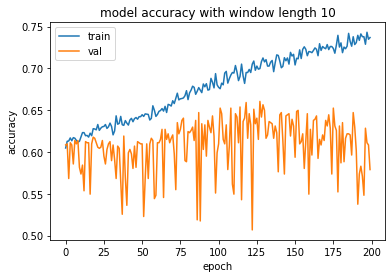

In [90]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

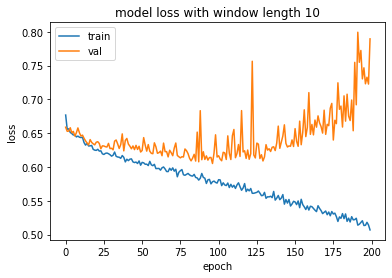

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [92]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

118/118 [==============================] - 0s 178us/step
for window length 10 we have: test loss, test acc: [0.9766766115770502, 0.6355932354927063]


**Next, we train the model with window size 20 to see how the increase of window size affects the test accuracy**

In [49]:
training_data, training_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, window_in_days=20)

model = build_model(training_data.shape, optimizer)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

In [50]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=200,
                    validation_split=0.2)

Train on 2982 samples, validate on 746 samples
Epoch 1/200
2982/2982 [==============================] - 3s 1ms/step - loss: 0.6779 - binary_accuracy: 0.5989 - val_loss: 0.6613 - val_binary_accuracy: 0.6086
Epoch 2/200
2982/2982 [==============================] - 3s 853us/step - loss: 0.6581 - binary_accuracy: 0.6107 - val_loss: 0.6545 - val_binary_accuracy: 0.6113
Epoch 3/200
2982/2982 [==============================] - 3s 840us/step - loss: 0.6573 - binary_accuracy: 0.6123 - val_loss: 0.6453 - val_binary_accuracy: 0.6166
Epoch 4/200
2982/2982 [==============================] - 3s 847us/step - loss: 0.6499 - binary_accuracy: 0.6123 - val_loss: 0.6520 - val_binary_accuracy: 0.5791
Epoch 5/200
2982/2982 [==============================] - 3s 839us/step - loss: 0.6508 - binary_accuracy: 0.6144 - val_loss: 0.6356 - val_binary_accuracy: 0.6139
Epoch 6/200
2982/2982 [==============================] - 2s 835us/step - loss: 0.6517 - binary_accuracy: 0.6167 - val_loss: 0.6321 - val_binary_accura

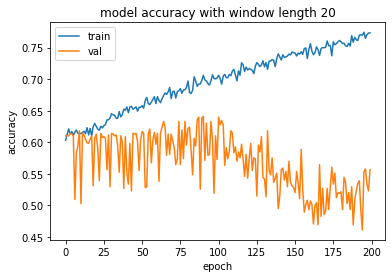

In [56]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 20')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

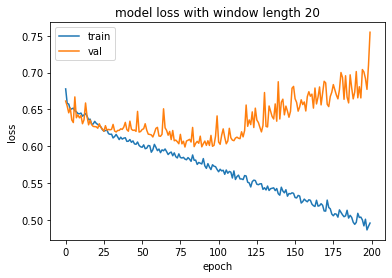

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [53]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 20 we have: test loss, test acc:', results)

108/108 [==============================] - 0s 286us/step
for window length 20 we have: test loss, test acc: [0.9266377135559365, 0.5648148059844971]


**And finally, we set the window length to 30 days.**

In [54]:
training_data, training_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, window_in_days=30)

model = build_model(training_data.shape, optimizer)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_6 (Batch (None, 16)                64        
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                

In [55]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=200,
                    validation_split=0.2)

Train on 2974 samples, validate on 744 samples
Epoch 1/200
2974/2974 [==============================] - 4s 1ms/step - loss: 0.6674 - binary_accuracy: 0.6032 - val_loss: 0.6572 - val_binary_accuracy: 0.6102
Epoch 2/200
2974/2974 [==============================] - 3s 1ms/step - loss: 0.6558 - binary_accuracy: 0.6126 - val_loss: 0.6575 - val_binary_accuracy: 0.6102
Epoch 3/200
2974/2974 [==============================] - 3s 1ms/step - loss: 0.6511 - binary_accuracy: 0.6210 - val_loss: 0.6434 - val_binary_accuracy: 0.6102
Epoch 4/200
2974/2974 [==============================] - 3s 1ms/step - loss: 0.6452 - binary_accuracy: 0.6133 - val_loss: 0.6403 - val_binary_accuracy: 0.6142
Epoch 5/200
2974/2974 [==============================] - 3s 1ms/step - loss: 0.6511 - binary_accuracy: 0.6170 - val_loss: 0.6339 - val_binary_accuracy: 0.6129
Epoch 6/200
2974/2974 [==============================] - 3s 1ms/step - loss: 0.6500 - binary_accuracy: 0.6110 - val_loss: 0.6580 - val_binary_accuracy: 0.6102

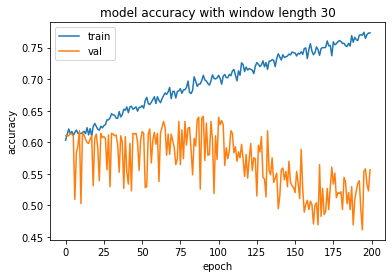

In [57]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 30')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

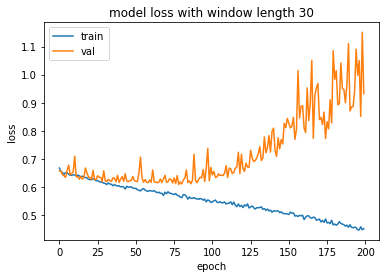

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 30')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 30 we have: test loss, test acc:', results)

98/98 [==============================] - 0s 380us/step
for window length 30 we have: test loss, test acc: [1.5055814056980366, 0.44897958636283875]


**Now, Let's train the model with window size of 10 again, but increase the number of epochs to 1000**

In [0]:
training_data, training_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end)

model = build_model(training_data.shape, optimizer)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

In [0]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=1000,
                    validation_split=0.2)

Train on 2990 samples, validate on 748 samples
Epoch 1/1000
2990/2990 [==============================] - 2s 742us/step - loss: 0.6757 - binary_accuracy: 0.5980 - val_loss: 0.6565 - val_binary_accuracy: 0.6096
Epoch 2/1000
2990/2990 [==============================] - 2s 502us/step - loss: 0.6615 - binary_accuracy: 0.6077 - val_loss: 0.6622 - val_binary_accuracy: 0.6096
Epoch 3/1000
2990/2990 [==============================] - 2s 508us/step - loss: 0.6512 - binary_accuracy: 0.6137 - val_loss: 0.6562 - val_binary_accuracy: 0.5348
Epoch 4/1000
2990/2990 [==============================] - 2s 508us/step - loss: 0.6524 - binary_accuracy: 0.6144 - val_loss: 0.6536 - val_binary_accuracy: 0.6136
Epoch 5/1000
2990/2990 [==============================] - 2s 507us/step - loss: 0.6515 - binary_accuracy: 0.6124 - val_loss: 0.6401 - val_binary_accuracy: 0.6136
Epoch 6/1000
2990/2990 [==============================] - 2s 506us/step - loss: 0.6491 - binary_accuracy: 0.6124 - val_loss: 0.6496 - val_binar

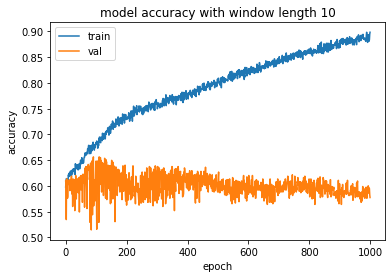

In [0]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

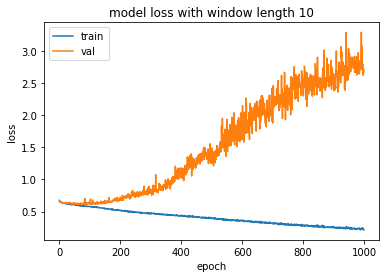

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

118/118 [==============================] - 0s 164us/step
for window length 10 we have: test loss, test acc: [11.517202619778908, 0.5932203531265259]


**Now let's remove dropout layer and repeat the experiment with window length of 10**

First of all, let's set number of epochs to 200

In [0]:
training_data, training_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end)

In [0]:

layers = [
          LSTM(64, input_shape=(training_data.shape[1], training_data.shape[2])),
          Dense(32),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

In [0]:
model = build_model(training_data.shape, optimizer, layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

In [0]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=200,
                    validation_split=0.2)

Train on 2990 samples, validate on 748 samples
Epoch 1/200
2990/2990 [==============================] - 3s 1ms/step - loss: 0.6703 - binary_accuracy: 0.5997 - val_loss: 0.6630 - val_binary_accuracy: 0.6096
Epoch 2/200
2990/2990 [==============================] - 2s 513us/step - loss: 0.6524 - binary_accuracy: 0.6057 - val_loss: 0.6565 - val_binary_accuracy: 0.6096
Epoch 3/200
2990/2990 [==============================] - 2s 510us/step - loss: 0.6472 - binary_accuracy: 0.6184 - val_loss: 0.6477 - val_binary_accuracy: 0.6110
Epoch 4/200
2990/2990 [==============================] - 2s 513us/step - loss: 0.6476 - binary_accuracy: 0.6184 - val_loss: 0.6426 - val_binary_accuracy: 0.6096
Epoch 5/200
2990/2990 [==============================] - 2s 511us/step - loss: 0.6487 - binary_accuracy: 0.6140 - val_loss: 0.6378 - val_binary_accuracy: 0.5909
Epoch 6/200
2990/2990 [==============================] - 2s 503us/step - loss: 0.6440 - binary_accuracy: 0.6187 - val_loss: 0.6319 - val_binary_accura

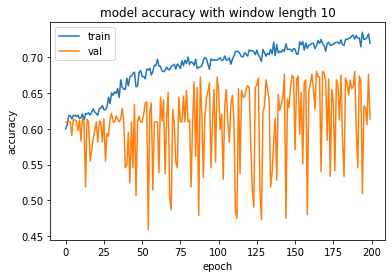

In [0]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

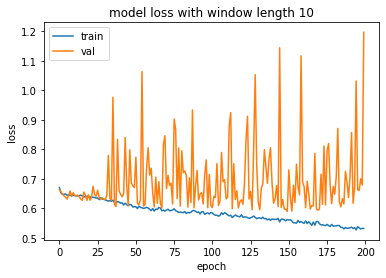

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

118/118 [==============================] - 0s 178us/step
for window length 10 we have: test loss, test acc: [64.23769811856545, 0.4067796468734741]


Now, let's set number of epochs to 1000

In [0]:
training_data, training_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end)

model = build_model(training_data.shape, optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

In [0]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=1000,
                    validation_split=0.2)

Train on 2990 samples, validate on 748 samples
Epoch 1/1000
2990/2990 [==============================] - 2s 824us/step - loss: 0.6037 - binary_accuracy: 0.6759 - val_loss: 0.5999 - val_binary_accuracy: 0.6604
Epoch 2/1000
2990/2990 [==============================] - 2s 589us/step - loss: 0.5714 - binary_accuracy: 0.6913 - val_loss: 0.6344 - val_binary_accuracy: 0.6096
Epoch 3/1000
2990/2990 [==============================] - 2s 595us/step - loss: 0.5681 - binary_accuracy: 0.6957 - val_loss: 0.6034 - val_binary_accuracy: 0.6618
Epoch 4/1000
2990/2990 [==============================] - 2s 594us/step - loss: 0.5518 - binary_accuracy: 0.7221 - val_loss: 0.7649 - val_binary_accuracy: 0.6136
Epoch 5/1000
2990/2990 [==============================] - 2s 594us/step - loss: 0.5516 - binary_accuracy: 0.7154 - val_loss: 0.6233 - val_binary_accuracy: 0.6444
Epoch 6/1000
2990/2990 [==============================] - 2s 589us/step - loss: 0.5452 - binary_accuracy: 0.7204 - val_loss: 0.9747 - val_binar

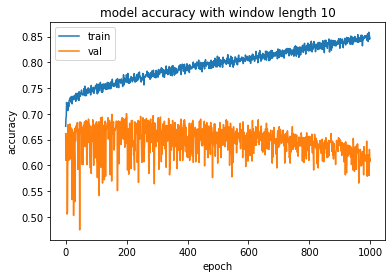

In [0]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

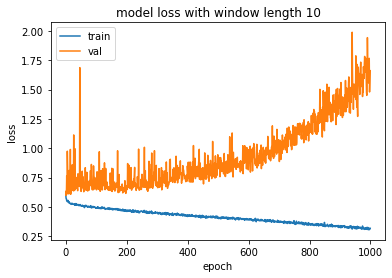

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
results = model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

118/118 [==============================] - 0s 179us/step
for window length 10 we have: test loss, test acc: [129.78779783087262, 0.6016949415206909]


**Now, Let's train the model on the whole dataset with no test data, also with window length of 10**

In [0]:
_training_end = pandas.to_datetime('20200501', format='%Y%m%d', errors='ignore')

training_data, training_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, _training_end, None, None, test_required=False)

model = build_model(training_data.shape, optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [0]:
history = model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=1000,
                    )

Epoch 1/1000
4356/4356 [==============================] - 4s 917us/step - loss: 0.6800 - binary_accuracy: 0.5764
Epoch 2/1000
4356/4356 [==============================] - 2s 463us/step - loss: 0.6663 - binary_accuracy: 0.5934
Epoch 3/1000
4356/4356 [==============================] - 2s 498us/step - loss: 0.6619 - binary_accuracy: 0.6024
Epoch 4/1000
4356/4356 [==============================] - 2s 474us/step - loss: 0.6585 - binary_accuracy: 0.5999
Epoch 5/1000
4356/4356 [==============================] - 2s 478us/step - loss: 0.6581 - binary_accuracy: 0.6006
Epoch 6/1000
4356/4356 [==============================] - 2s 455us/step - loss: 0.6594 - binary_accuracy: 0.5980
Epoch 7/1000
4356/4356 [==============================] - 2s 481us/step - loss: 0.6548 - binary_accuracy: 0.6026
Epoch 8/1000
4356/4356 [==============================] - 2s 495us/step - loss: 0.6559 - binary_accuracy: 0.6015
Epoch 9/1000
4356/4356 [==============================] - 2s 497us/step - loss: 0.6526 - binary_

Let's save the achieved model for further use.

In [0]:
model.save(join(COLAB_DIR,'model.h5'))

## **Transfer Learning part**

In this section, we load the pre-trained model and then do partial tuning with training it on the stock with second max trading days. Then, we test it to get accuracy of the model

In [0]:
stock_with_second_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[1]

In [0]:
train_start = pandas.to_datetime('20100101', format='%Y%m%d', errors='ignore')
train_end = pandas.to_datetime('20160719', format='%Y%m%d', errors='ignore')
test_start = pandas.to_datetime('20170101', format='%Y%m%d', errors='ignore')
test_end = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')

Next, we load the pretrained model

In [0]:
from keras.models import load_model

training_data, training_labels, testing_data, testing_labels = \
      generate_datasets_for_model(data, labels, stock_with_second_max_trading_days, train_start, train_end, test_start, test_end)

base_model = build_model(training_data.shape, optimizer)
base_model.load_weights(join(COLAB_DIR,'model.h5'))
base_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_8 (Batch (None, 16)                64        
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                

In [0]:
history = base_model.fit(training_data, training_labels,
                    batch_size=32,
                    epochs=500,
                    validation_split=0.2)

Train on 1260 samples, validate on 315 samples
Epoch 1/500
1260/1260 [==============================] - 1s 789us/step - loss: 1.3078 - binary_accuracy: 0.5746 - val_loss: 0.7609 - val_binary_accuracy: 0.4921
Epoch 2/500
1260/1260 [==============================] - 0s 378us/step - loss: 0.6518 - binary_accuracy: 0.6111 - val_loss: 0.6942 - val_binary_accuracy: 0.5111
Epoch 3/500
1260/1260 [==============================] - 0s 372us/step - loss: 0.6301 - binary_accuracy: 0.6190 - val_loss: 0.6971 - val_binary_accuracy: 0.5206
Epoch 4/500
1260/1260 [==============================] - 0s 359us/step - loss: 0.6164 - binary_accuracy: 0.6437 - val_loss: 0.6863 - val_binary_accuracy: 0.5524
Epoch 5/500
1260/1260 [==============================] - 0s 370us/step - loss: 0.6073 - binary_accuracy: 0.6587 - val_loss: 0.6947 - val_binary_accuracy: 0.5492
Epoch 6/500
1260/1260 [==============================] - 0s 364us/step - loss: 0.5890 - binary_accuracy: 0.6714 - val_loss: 0.6809 - val_binary_accu

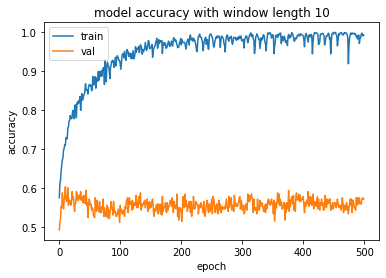

In [0]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

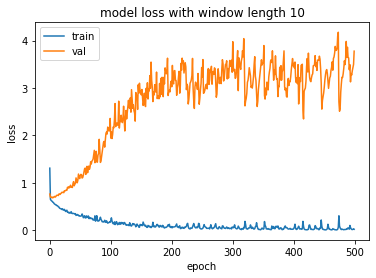

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
results = base_model.evaluate(testing_data, testing_labels)
print('for window length 10 we have: test loss, test acc:', results)

234/234 [==============================] - 0s 124us/step
for window length 10 we have: test loss, test acc: [38.91098756056566, 0.5341880321502686]
